<a href="https://colab.research.google.com/github/amikoshimrah/Deployment/blob/main/RNN_based_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**✅ STEP 1: Setup and Data Preparation**

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
# Load datasets
train_data = pd.read_csv('twitter_training.csv', header=None)
val_data = pd.read_csv('twitter_validation.csv', header=None)

# Assign column names based on dataset format
train_data.columns = ['id', 'entity', 'sentiment', 'text']
val_data.columns = ['id', 'entity', 'sentiment', 'text']


**✅ STEP 2: Preprocessing and Feature Engineering**

In [ ]:
# --- Clean Text ---
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r"[^\w\s]", '', text)
    return text

In [ ]:
# Fill nulls and clean
train_data['text'] = train_data['text'].fillna('')
val_data['text'] = val_data['text'].fillna('')
train_data['clean_text'] = train_data['text'].apply(clean_text)
val_data['clean_text'] = val_data['text'].apply(clean_text)

In [ ]:
# --- Filter Expected Sentiments ---
expected_sentiments = ['Positive', 'Neutral', 'Negative']
train_data = train_data[train_data['sentiment'].isin(expected_sentiments)]
val_data = val_data[val_data['sentiment'].isin(expected_sentiments)]


In [ ]:
# --- Encode Labels ---
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['sentiment'])
val_data['label'] = label_encoder.transform(val_data['sentiment'])

<ipython-input-6-985157f8f423>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = label_encoder.fit_transform(train_data['sentiment'])
<ipython-input-6-985157f8f423>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['label'] = label_encoder.transform(val_data['sentiment'])


In [ ]:
# --- Tokenize and Pad ---
tokenizer = Tokenizer(num_words=65000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['clean_text'])

train_sequences = tokenizer.texts_to_sequences(train_data['clean_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['clean_text'])

max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    train_padded,
    train_data['label'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['label']
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(49353, 100)
(12339, 100)
(49353,)
(12339,)


In [ ]:
# Convert to NumPy arrays with valid dtypes
X_train = np.array(X_train, dtype='int32')
X_test = np.array(X_test, dtype='int32')
y_train = np.array(y_train, dtype='int32')
y_test = np.array(y_test, dtype='int32')

**✅ STEP 3: Build RNN Model**

In [ ]:
# --- Build ANN Model ---
model = Sequential([
    Embedding(input_dim=65000, output_dim=16, input_length=max_length),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │     1,040,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,040,323 (3.97 MB)

 Trainable params: 1,040,323 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

**✅ STEP 4: Train the Model**

In [ ]:
# --- Train Model with EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=50,
    callbacks=[early_stop]
)



Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3577 - loss: 1.0950 - val_accuracy: 0.4538 - val_loss: 1.0838
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4159 - loss: 1.0751 - val_accuracy: 0.5303 - val_loss: 1.0114
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5421 - loss: 0.9837 - val_accuracy: 0.5915 - val_loss: 0.8899
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6195 - loss: 0.8684 - val_accuracy: 0.6608 - val_loss: 0.8006
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6821 - loss: 0.7771 - val_accuracy: 0.7148 - val_loss: 0.7306
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7163 - loss: 0.7093 - val_accuracy: 0.7332 - val_loss: 0.6765
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7474 - loss: 0.6471 - val_accuracy: 0.7451 - val_loss: 0.6368
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7544 - loss: 0.6128 - val_accu

**✅ STEP 5: Evaluate the Model**

In [ ]:
# --- Evaluate Model ---
val_preds = model.predict(X_test)
val_preds_labels = np.argmax(val_preds, axis=1)

print("Classification Report:\n")
print(classification_report(y_test, val_preds_labels, target_names=label_encoder.classes_))

386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:

              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88      4509
     Neutral       0.91      0.80      0.85      3664
    Positive       0.87      0.87      0.87      4166

    accuracy                           0.87     12339
   macro avg       0.87      0.86      0.87     12339
weighted avg       0.87      0.87      0.87     12339



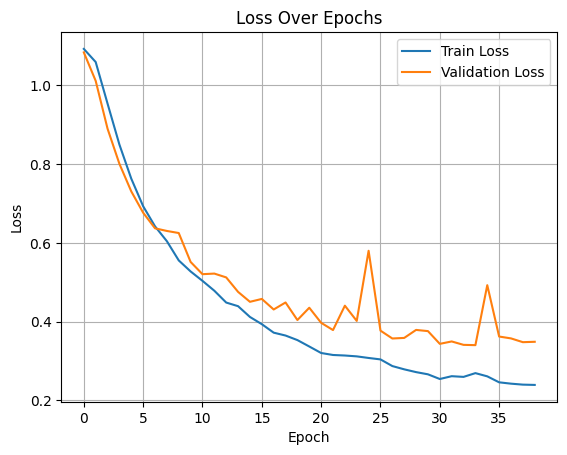

In [ ]:
# --- Plot Training History ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


**✅ STEP 6: Fine-tuning and Optimization**

In [ ]:
# Alternative optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# --- Train Model with EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
348/348 - 5s - 16ms/step - accuracy: 0.8992 - loss: 0.2680 - val_accuracy: 0.8957 - val_loss: 0.2620
Epoch 2/50
348/348 - 5s - 16ms/step - accuracy: 0.8995 - loss: 0.2650 - val_accuracy: 0.8955 - val_loss: 0.2574
Epoch 3/50
348/348 - 5s - 14ms/step - accuracy: 0.9055 - loss: 0.2540 - val_accuracy: 0.9084 - val_loss: 0.2230
Epoch 4/50
348/348 - 5s - 14ms/step - accuracy: 0.9068 - loss: 0.2465 - val_accuracy: 0.9068 - val_loss: 0.2400
Epoch 5/50
348/348 - 4s - 11ms/step - accuracy: 0.9064 - loss: 0.2480 - val_accuracy: 0.8630 - val_loss: 0.3687
Epoch 6/50
348/348 - 4s - 11ms/step - accuracy: 0.9072 - loss: 0.2475 - val_accuracy: 0.8537 - val_loss: 0.3643


In [ ]:
# --- Evaluate Model ---
val_preds = model.predict(X_test)
val_preds_labels = np.argmax(val_preds, axis=1)

print("Classification Report:\n")
print(classification_report(y_test, val_preds_labels, target_names=label_encoder.classes_))

386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:

              precision    recall  f1-score   support

    Negative       0.93      0.84      0.88      4509
     Neutral       0.76      0.92      0.83      3664
    Positive       0.91      0.84      0.87      4166

    accuracy                           0.86     12339
   macro avg       0.87      0.86      0.86     12339
weighted avg       0.87      0.86      0.86     12339



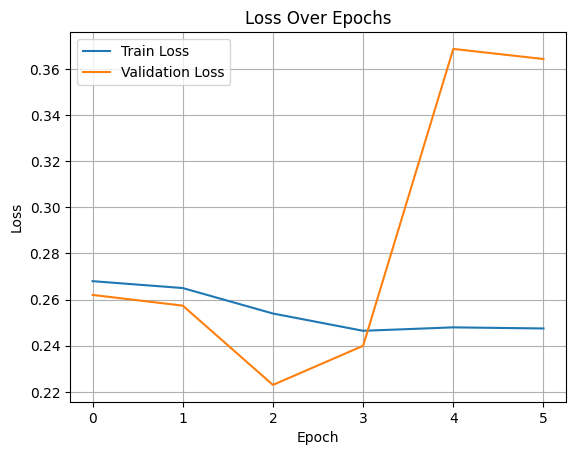

In [ ]:
# --- Plot Training History ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# --- Evaluate Model ---
val_preds = model.predict(X_test)
val_preds_labels = np.argmax(val_preds, axis=1)

print("Classification Report:\n")
print(classification_report(y_test, val_preds_labels, target_names=label_encoder.classes_))

386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:

              precision    recall  f1-score   support

    Negative       0.93      0.84      0.88      4509
     Neutral       0.76      0.92      0.83      3664
    Positive       0.91      0.84      0.87      4166

    accuracy                           0.86     12339
   macro avg       0.87      0.86      0.86     12339
weighted avg       0.87      0.86      0.86     12339

